In [10]:
import pandas as pd
import numpy as np

# Membaca file CSV
place = pd.read_csv('/content/place_rating_cleaned.csv')

# Tampilkan 5 baris pertama untuk memastikan data terbaca dengan benar
print(place.head(5))

# Fungsi untuk meng-encode kolom menjadi angka
def dict_encoder(col, data=place):
    # Mengubah kolom suatu dataframe menjadi list tanpa nilai yang sama
    unique_val = data[col].unique().tolist()

    # Melakukan encoding value kolom suatu dataframe ke angka
    val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}

    # Melakukan proses encoding angka ke value dari kolom suatu dataframe
    val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
    return val_to_val_encoded, val_encoded_to_val

# Encoding User_Id
user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id')
place['user'] = place['User_Id'].map(user_to_user_encoded)

# Encoding Place_Id
place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id')
place['place'] = place['Place_Id'].map(place_to_place_encoded)

# Encoding Category
category_to_category_encoded, category_encoded_to_category = dict_encoder('Category')
place['category'] = place['Category'].map(category_to_category_encoded)

# Menentukan jumlah pengguna dan tempat
num_users, num_places = len(user_to_user_encoded), len(place_to_place_encoded)

# Mengubah nilai rating menjadi tipe data float
place['Place_Ratings'] = place['Place_Ratings'].values.astype(np.float32)

# Menentukan rating minimum dan maksimum
min_rating, max_rating = min(place['Place_Ratings']), max(place['Place_Ratings'])

# Cetak informasi
print(f'Number of Users: {num_users}, Number of Places: {num_places}, Min Rating: {min_rating}, Max Rating: {max_rating}')

# Normalisasi rating
y = place['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Pisahkan fitur
x = place[['user', 'place', 'category']].values

# Bagi data menjadi data latih dan data validasi
train_indices = int(0.8 * place.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

# Tampilkan hasil pembagian data
print("x_train:\n", x_train)
print("x_val:\n", x_val)
print("y_train:\n", y_train)
print("y_val:\n", y_val)


   User_Id  Place_Id  Place_Ratings       Category        City    Price  \
0        1       179              3         Budaya  Yogyakarta  75000.0   
1        1       344              2         Bahari    Semarang   3000.0   
2        1         5              5  Taman Hiburan     Jakarta  94000.0   
3        1       373              3         Budaya    Semarang  10000.0   
4        1       312              2     Cagar Alam     Bandung  11000.0   

                       Place_Name  
0                 Candi Ratu Boko  
1                   Pantai Marina  
2        Atlantis Water Adventure  
3          Museum Kereta Ambarawa  
4  Taman Hutan Raya Ir. H. Juanda  
Number of Users: 300, Number of Places: 300, Min Rating: 1.0, Max Rating: 5.0
x_train:
 [[  0   0   0]
 [  0   1   1]
 [  0   2   2]
 ...
 [240 235   3]
 [240 181   1]
 [240 191   1]]
x_val:
 [[240 276   3]
 [240  21   3]
 [240  99   2]
 ...
 [299  84   0]
 [299 237   3]
 [299 170   3]]
y_train:
 [0.5  0.25 1.   ... 0.5  0.25 1.  ]

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout

embedding_dim = 50

user_input = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding')(user_input)
user_vec = Flatten(name='user_flatten')(user_embedding)

place_input = Input(shape=(1,), name='place_input')
place_embedding = Embedding(input_dim=num_places, output_dim=embedding_dim, name='place_embedding')(place_input)
place_vec = Flatten(name='place_flatten')(place_embedding)

concatenated = Concatenate(name='concatenate')([user_vec, place_vec])

# Add Dropout and Dense layers with regularization
dense = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='dense_1')(concatenated)
dense = Dropout(0.2)(dense)
dense = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='dense_2')(dense)
dense = Dropout(0.2)(dense)
dense = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='dense_3')(dense)
dense = Dropout(0.2)(dense)
output = Dense(1, activation='linear', name='output')(dense)

model = Model(inputs=[user_input, place_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])

model.summary()

history = model.fit(
    [x_train[:, 0], x_train[:, 1]],
    y_train,
    epochs=10,
    verbose=1,
    validation_data=([x_val[:, 0], x_val[:, 1]], y_val)
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 place_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 50)                15000     ['user_input[0][0]']          
                                                                                                  
 place_embedding (Embedding  (None, 1, 50)                15000     ['place_input[0][0]']         
 )                                                                                            

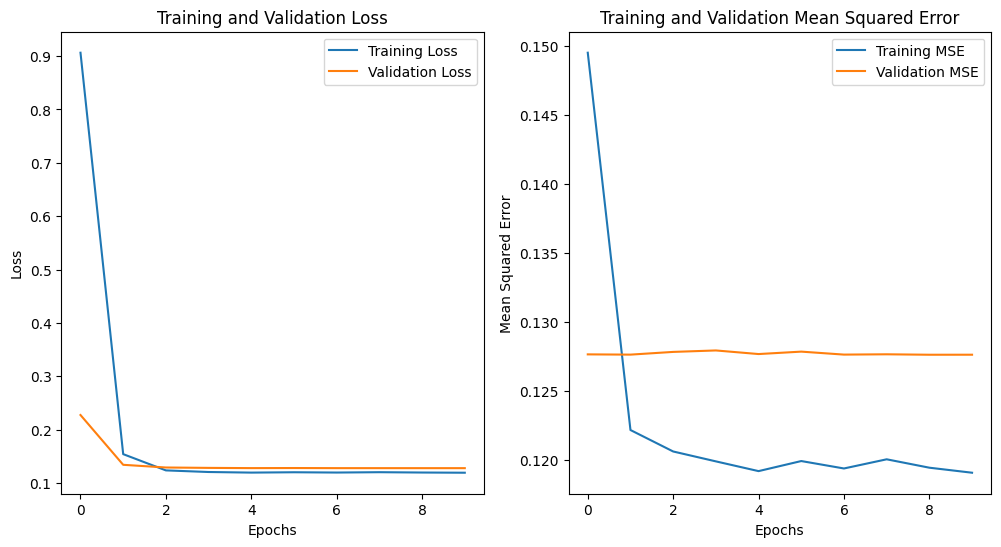

In [12]:
import matplotlib.pyplot as plt

# Menampilkan grafik Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Menampilkan grafik Mean Squared Error
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Training and Validation Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.show()

In [14]:
# Save the model to H5 file
model.save('data_wisata.h5')